# 1.  Health Data Science Scenario:

Our hospital has been very proactive in terms of analysing data of its electronic medical record (EMR). By analysing the data, they have made very interesing discoveries:

1. They identified that readmitted patients are not necessarily those who were sicker in the first admission, but those who had less support at home after discharge or those patients that did not have a medical follow-up after discharge.
2. Readmitted patients experienced high levels of emotional stress.
3. Readmitted patients were at much higher risk of acquiring new infections while at hospital.
4. Readmissions are highly costly. Patients that were readmitted for the reasons cited above tended to be sicker than they were when they were first admitted and their length of stay was significantly longer than their first admission.

Our hospital has trialed a "specialised unit" that coordinates the patient's discharge. A team of nurses and OTs visit the patient's home after discharge. The frequency of the visits depends upon an assessment made before discharge, but the average number of visits is 5 across the board. Amongst other things, they make sure that the wounds are healing properly, medication is taken, that there is coordination with a GP in place and basic daily activities can be done, such as moving around their home, toilet, cooking, ...
In addition, the specialised unit regularly contacts the patients via telephone to check that everything is going well. The patients can also contact the specialised unit if they need any help. 

This pilot has drastically reduced the number of readmissions. 

In addition, the cost of operating the specialised unit was much cheaper than the cost of readmissions.

In terms of budget:

1. A day in hospital costs 5000 per day on average, readmitted patients tend to stay an average of 4 days.
2. A home visit of the specialised unit costs 400; the average number of visits is 5. 
3. No targeted patients: 0

Our hospital is now ready to roll out and implement the specialised unit service to all patients at risk for readmission. 
The problem is that a priori, they do not know which patients are at risk of readmission. Thus, they do not know the patients they should be targeting.


<b><font color=green>Goal/Research Question: </font>
1. The hospital needs a machine learning algorithm to predict which patients should participate in the "discharge intervention". They are hiring you to build this algorithm.

2. You will need to explain to the hospital managers the performance of your algoritm, so they can make an informed decision whether to use your algorithm or not.


# 2. Instructions

These are the specifications (step 0 of our machine learning work-flow- Question):

1. We are going to deliver one predictive model to predict readmission to hospital within 30 days of discharge. 

2. They want the algorithm to capture as many "readmissions" as posible (true positives) even at the expense of <font color='green'><b> moderately</b> </font> increasing the number of false positives <font color='green'><b>  within reason</b></font> (that is, patients that are not at risk of readmission that are classified as readmission). 

3. Nevertheless, we must take into account that the hospital does not have unlimited resources, so they cannot considered a high number of patients at risk of readmission because the cost of the "specialised unit" would be very high.  

4. You will design several machine learning algorithms, choose one, and give a rationale explaining why you choose that algorithm. 

    * Build some predictive models to predict readmission to hospital within 30 days of discharge using:  
        *  'Logistic Regression Classifiers'.
        * 'Random Forest Classifier'. 
     
        
5. Use the evaluation metrics that you consider useful to evaluate your models. 

# 4. Load the diabetes dataset previously prepared in Chapter 2

**Let's load the 'diabetes' dataset that we saved in Chapter 2,  by using 'pickle'.**

In [3]:
import sys
import numpy as np
import pandas as pd
from IPython.display import display
from plotnine import *
import warnings; warnings.simplefilter('ignore')

In [4]:
import pickle

# Load dataset stored in pickle in Exercise 1
with open('hospital_data.pickle', 'rb') as data:
    hospital = pickle.load(data)

# Check
hospital.head()

,Age,los,number_diagnoses,num_lab_procedures,num_procedures,num_medications,number_emergency,number_inpatient,number_outpatient,sex_Female,...,admission_source_grouped_Other,admission_source_grouped_Physician Referral,admission_source_grouped_Transfer from another health care facility,admission_type_grouped_Elective,admission_type_grouped_Emergency,admission_type_grouped_Newborn,admission_type_grouped_Not Available/Null,admission_type_grouped_Trauma Centre,admission_type_grouped_Urgent,readmission
0,57,11,13,79,9,35,2,0,5,1,...,0,1,0,0,0,0,0,0,1,yes
1,52,2,3,49,1,11,0,0,0,1,...,0,1,0,1,0,0,0,0,0,no
2,83,4,9,68,2,23,0,0,0,1,...,0,0,0,0,1,0,0,0,0,no
3,80,3,9,46,0,20,0,0,0,1,...,0,0,0,0,1,0,0,0,0,no
4,34,5,3,49,0,5,0,0,0,1,...,0,0,0,0,1,0,0,0,0,no


Please note that our 'diabetes' dataset is already cleaned and have dummy variables. 

In [5]:
# Importing the necessary packages for the random forest and logistic regression model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Import evaluation metrics 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

#import lime and shap packages
import lime
import lime.lime_tabular
import shap                
import time

Below, further data preparation is conducted to separate the outcome variable from the features.  Also, the outcome variable is changed to binary to be used in the logistic regression model.  

In [6]:
# Dividing the dataset in X and y (outcome)
X = hospital.drop(axis=1, columns=['readmission'])
y = hospital['readmission']

# Create y_binary
y_binary = [0 if x=='no' else 1 for x in y]


# 3.1 Logistic Regression Model

In this section, I will fit a logistic model to predict readmissions using the 'diabetes' dataset.  A logisitic model has a few parameters (C, class weight, and penalty) that I will tune to choose the optimal parameter selection. The optimal parameters will be the parameters that maximize the recall of the model, or the model that correctly predicts a high proportion of the total readmission population.  

**Training and Hyper-Parameter Tuning**

First, the dataset is split into a training and test set.  20% of the data is set aside to be used as the test dataset. The random state is set to zero to ensure this process is reproducible.   

In [7]:
# Split X and y into 80% train and 20% test data (roughly), set random state for reproducability and stratify responses
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=0, stratify = y)

Below, the scaling function, logistic model, and pipeline are initialized to be used in GridsearchCV.  Standardized scaling will be used for all of the features in the model.  Since the C, class weight, and penalty hyper-parameters are all going to be tuned, the logistic regression model is also initialized using the _liblearner_ solver.  

In [6]:
# Scaler/Standardization

Scaler = StandardScaler()

# Logistic Model
Log_Reg = LogisticRegression(solver='liblinear')

# PipeLine: 
pipe = Pipeline([('Transform', Scaler), ('Estimator',Log_Reg)])

To find the optimal hyper-parameters to use in the logistic regression model, I first define the parameter grid of values to evaluate.  In this model, I am interested in the _C_ estimator, the class weight, and the penalty to use.  

The _C_ estimator search space is defined using a range of standard value options at the start. The class weights will fall between 0 and 1, so values are explored from .2 to .8 increasing by .2.  Lastly, both the _l1_ and _l2_ penalty will be evaluated. 

In [7]:
#List of weights to test for .2，.4，.6，.8

weights = (.2,.4,.6,.8)

#Defining the parameters grid:
param_grid = {'Estimator__C': [0.001, 0.01, 0.1, 1, 10, 100],
             'Estimator__class_weight':[{0: x, 1: 1.0-x} for x in weights],
             'Estimator__penalty':['l1','l2']}

#print grid to ensure correct
print("Parameter grid:")
print("C: {}".format(param_grid['Estimator__C']))
print("Class Weight: {}".format(param_grid['Estimator__class_weight']))
print("Penalty: {}".format(param_grid['Estimator__penalty']))


Parameter grid:
C: [0.001, 0.01, 0.1, 1, 10, 100]
Class Weight: [{0: 0.2, 1: 0.8}, {0: 0.4, 1: 0.6}, {0: 0.6, 1: 0.4}, {0: 0.8, 1: 0.19999999999999996}]
Penalty: ['l1', 'l2']


Once the parameter grid is defined, the GridsearchCV object is created using the pipeline defined above, the grid of possible parameters, a cross-validation fold of five, and the scoring metric to maximize is set to _recall_.  Recall is used as the scoring metric because the hospital is interested in maximizing the amount of readmissions captured at the expense of identifying patients not at risk of readmission. 

In [9]:
#GridsearchCV with five folds
grid_search = GridSearchCV(pipe, param_grid, cv=5,n_jobs=-1,
                          return_train_score=True,scoring='recall')

Once the grid_search object is defined, I can then tune the hyper-parameters and train the logisitic regression model using the training data defined above. 

The best parameter options and resulting cross-validation _recall_ score are then printed out. 

In [10]:
#using training data to fit model and find optimal hyper-parameters
grid_search.fit(X_train, y_train)

#print the best parameters and return highest CV score
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.4f}".format(grid_search.best_score_))

# Getting the accuracy from the test and training data
print("Accuracy on training set: {:.3f}".format(grid_search.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(grid_search.score(X_test, y_test)))


Best parameters: {'Estimator__C': 0.001, 'Estimator__class_weight': {0: 0.2, 1: 0.8}, 'Estimator__penalty': 'l1'}
Best cross-validation score: 0.5649
Accuracy on training set: 0.565
Accuracy on test set: 0.562


When maximizing for _recall_, the optimal hyper-parameters found are 0.001 for C, (0:0.2,1:0.8) for class weight, and _l1_ for penalty.  With these hyper-parameters the best _recall_ cross-validation score is 0.5649. Additionally, the accuracy on the training data is 0.565 and 0.562 for the testing data, which indicates that the model is not over-fitting to the training data. 

Below, I will try a few more hyper-parameter options for C and class weight to check for any performance impact around the selected values. 

The parameter grid is updated to search additional _C_ estimators and class weights close in value to the selected values above.  The penalty remains as _l1_. 

In [9]:
# because the best parameters are .2 so compare it to the neighboring ones.
weights = (.1,.15,.2,.25,.3)

#Defining the parameters grid:
param_grid_2 = {'Estimator__C': [0.001,0.002],
             'Estimator__class_weight':[{0: x, 1: 1.0-x} for x in weights],
             'Estimator__penalty':['l1']}

#print grid to ensure correct
print("Parameter grid:")
print("C: {}".format(param_grid_2['Estimator__C']))
print("Class Weight: {}".format(param_grid_2['Estimator__class_weight']))
print("Penalty: {}".format(param_grid_2['Estimator__penalty']))

Parameter grid:
C: [0.001, 0.002]
Class Weight: [{0: 0.1, 1: 0.9}, {0: 0.15, 1: 0.85}, {0: 0.2, 1: 0.8}, {0: 0.25, 1: 0.75}, {0: 0.3, 1: 0.7}]
Penalty: ['l1']


Same as above, GridSearchCV is used to define the object, tune the hyper-parameters, and train the model using the training data. The resulting best parameters and cross-validation score is printed out. 

In [10]:
#GridsearchCV with five folds
grid_search_2 = GridSearchCV(pipe, param_grid_2, cv=5,n_jobs=-1,
                          return_train_score=True,scoring='recall')

In [11]:
#using training data to fit model and find optimal hyper-parameters
grid_search_2.fit(X_train, y_train)

#print the best parameters and return highest CV score
print("Best parameters: {}".format(grid_search_2.best_params_))
print("Best cross-validation score: {:.4f}".format(grid_search_2.best_score_))

# Getting the accuracy from the test and training data
print("Accuracy on training set: {:.3f}".format(grid_search_2.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(grid_search_2.score(X_test, y_test)))

Best parameters: {'Estimator__C': 0.002, 'Estimator__class_weight': {0: 0.1, 1: 0.9}, 'Estimator__penalty': 'l1'}
Best cross-validation score: 0.5956
Accuracy on training set: 0.603
Accuracy on test set: 0.599


After searching the space around the initial hyper-parameters, the optimal hyper-parameters found are now 0.002 for C, (0:0.1,1:0.9) for class weight, and _l1_ for penalty.  With these hyper-parameters the best _recall_ cross-validation score is 0.5956. The accuracy is 0.603 and 0.599 for the training and test data respectively, an increase when compared to the previous model. 

This model has a higher value of _recall_, capturing approximately 60% of the readmissions.  This model will be evaulated on the test data below to check the overall performance of the model on the testing data. 

# 3.2 Evaluation of the Logistic Regression model

Using the logistic regression model above, this section will evaluate the model's performance on the test data not used in the training of the model.  The model predictions are compared to the true values of the test data to evaluate the resulting scoring metrics and confusion matrix.  This evaluation is needed to examine the model's performance on future real world data.  The confusion matrix can also be used to calculate the resulting financial impact of utilizing the predicitons and interventions. 

First, the predicitions must be generated using the test data.  These predictions will be compared against the true values to calculate the scoring metrics and confusion matrix. The _pred_grid_search_ object is defined below. 

In [25]:
# Generate predictions for test data based on the model with best parameters generated by GridSearchCV 
pred_grid_search = grid_search_2.predict(X_test)


Below, the classification report is printed out to evaluate the resulting scoring metrics such as _precision_, _recall_, and the overall _f1_ score.  The first to observe is that recall below, 0.60, is close to the cross-validation training score from above, so the model is not overfitting the training data.  The model has a high recall, 0.60, but it comes at a cost and the precision of the model is low, .0.43 for predicting readmissions.  This will be studied further in the rest of the section. 

In [26]:
print(classification_report(y_test, pred_grid_search))

              precision    recall  f1-score   support

           0       0.91      0.84      0.87     11473
           1       0.43      0.60      0.50      2384

    accuracy                           0.80     13857
   macro avg       0.67      0.72      0.69     13857
weighted avg       0.83      0.80      0.81     13857



Further, I am interested in visualizing the relationship between precision and recall for this model.  At what cost can the recall be maximized?  The Precision-Recall curve below illustrates how precision and recall relate.  I observe that the precision is very high until the recall increases past 0.5.  At that point, there is a significant decrease in precision and it reaches its lowest value of ~0.2 when the recall is 1.0.  

[0.07066903 0.08132647 0.09497292 ... 0.10311147 0.09713775 0.10214062]


Text(0.5, 1.0, 'Precision-Recall Curve For Logistic Regression Model')

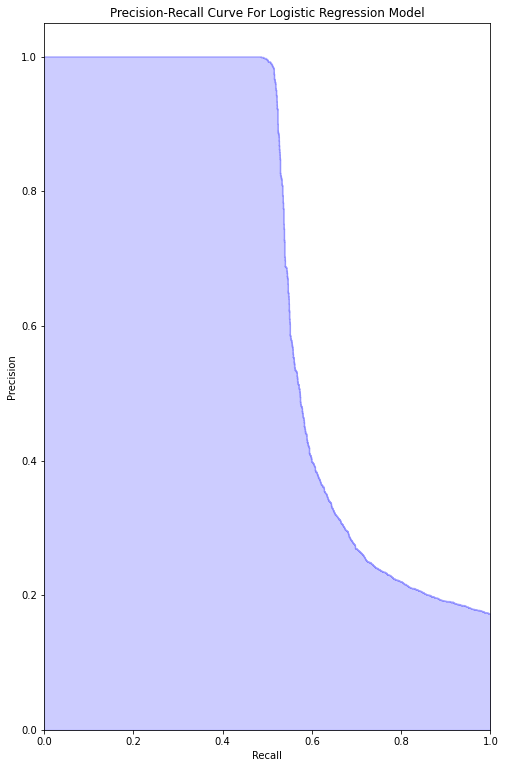

In [56]:
#predicted probabilities for readmission class in test data
y_score = grid_search_2.predict_proba(X_test)[:,-1]

#compute the precision recall pairs for different probability thresholds
precision, recall, _ = precision_recall_curve(y_test, y_score)

#plot the line
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')

#fill the plot
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

#set labels, limits, and title
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve For Logistic Regression Model')

Below, a confusion matrix is created and visualized to dive deeper into the model performance on the test data. The scoring metrics from above can be calculated using the values in the confusion matrix cells.  The values also give us a way to estimate the financial impact of using this model's predictions to drive interventions for patients at risk of readmission. 

[Text(0, 0.5, 'No'), Text(0, 1.5, 'Yes')]

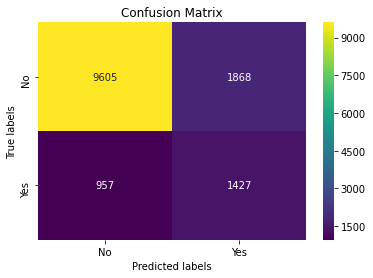

In [27]:
# Generate and visualize confusion matrix for evaluation

labels = [0, 1]

# Confusion Matrix
cm = metrics.confusion_matrix(y_true = y_test, y_pred = pred_grid_search, labels=labels)

# Visualising the confusion matrix 
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='.0f', ax= ax, cmap="viridis")

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['No', 'Yes']); ax.yaxis.set_ticklabels(['No', 'Yes'])

By observing the confusion matrix, I see that the model correctly predicts 1427 of the 2384 readmits in the test dataset (recall).  However, the model also predicts 1868 patients that are not readmits in the test dataset.  So overall, the model predicts 3295 readmissions but only 1427 of those were readmits (precision).  

Below, the values from above are calculated manually using the values in the confusion matrix to highlight above. 

In [28]:
# Output results from precision, recall, accuracy and f1 score
print('Results of applying model to test data:\n')
print(f'Recall: \t\t{round(cm[1][1]/(cm[1][1]+cm[1][0]),3)}')
print(f'Precision: \t\t{round(cm[1][1]/(cm[1][1]+cm[0][1]),3)}')
print(f'Accuracy: \t\t{round(grid_search_2.score(X_test,y_test),3)}')
print(f'F1 score: \t\t{round(f1_score(y_test, pred_grid_search),3)}')

Results of applying model to test data:

Recall: 		0.599
Precision: 		0.433
Accuracy: 		0.599
F1 score: 		0.503


Overall, the logistic regression model does a decent job of predicting readmissions. By finding the hyper-parameters that maximize the recall, the model correctly predicts approximately 60% of the total readmission population.  However, this comes at the expense of wrongly predicting a high number of patients that were not readmissions.  The intervention is expensive, so I will have to estimate whether the benefit of preventing readmissions for a large proportion of patients outweights the expense of applying the intervention to patients not at risk. 


# 3.3 Training, Hyperparemeter tuning of the Random Forests model

In this section, I will fit a random forest model to predict readmissions using the 'diabetes' dataset.  A random forest model has a few parameters (number of estimators, max features, and max tree depth) that I will tune to choose the optimal parameter selection.  Same as above, I will search for the parameters that maximize the recall score to ensure a high proportion of the total readmissions are predicted and thus receive the intervention.   

**Fitting the initial model**

First, as seen above, we split the data into the outcome (readmissions) and features. Thereafter the data was split into training and testing sets while readmissions was recoded as binary.

Next we initialized the random forest classifier and set potential hyperparameter values for the grid search. The intuition behind each list of values is as follows: overfitting random forests is generally a non issue, and therefore the potential range of trees in the forest (n_estimators) is vast. The suggested value for max_features in the Witten et al book is $\small{\sqrt{p}}$, but we inluded auto and log2 in order to cover other options. Max depth options span 5 to None because growing the trees until they are pure using None will result in high variance for a single tree, but averaging over many trees we can obtain low bias and lower variance.

Given that we are concerned with detecting true positives in the data the scoring option in GridSearchCV is set to recall

In [29]:
forest_grid = RandomForestClassifier(random_state = 0, oob_score = True)

In [30]:
param_grid = {'n_estimators': [10, 50, 100, 200],
              'max_features': ["sqrt", "auto", "log2"],
              'max_depth': [None, 5, 10, 15, 20, 25]}

In [31]:
grid_search = GridSearchCV(forest_grid, param_grid = param_grid, cv = 5, scoring = 'recall')

In [32]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=True, random_state=0,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'ma

In [33]:
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation average f1 score: {:.2f}".format(grid_search.best_score_))

Best parameters: {'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 100}
Best cross-validation average f1 score: 0.51


In [34]:
# Fitting the model with optimal parameters based on grid search
forest_opt = RandomForestClassifier(n_estimators = 100, random_state = 0, max_depth = 20, max_features = "sqrt", oob_score = True)
forest_opt.fit(X_test, y_test)
forest_opt.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=0, verbose=0,
                       warm_start=False)

**Initial model results**

Below we can see the accuracy of the model on the training, test, and out of bag data is fairly high. Further examination reveals that the f1 score for readmitted patients is .67. However, a recall value for readmitted patients of 0.51 indicates the model does not perform incredibly well regarding true positives. As such, we performed a second grid search around the best parameters from the first search in hopes of refining the model even further.

In [35]:
# Getting the accuracy from the test, training, and out of bag data
print("Accuracy on training set: {:.3f}".format(forest_opt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(forest_opt.score(X_test, y_test)))
print("Accuracy on the out of bag data: {:.3f}".format(forest_opt.oob_score_))

Accuracy on training set: 0.922
Accuracy on test set: 0.914
Accuracy on the out of bag data: 0.915


In [36]:
pred_grid_search = forest_opt.predict(X_test)
print(classification_report(y_test, pred_grid_search))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     11473
           1       0.99      0.51      0.67      2384

    accuracy                           0.91     13857
   macro avg       0.95      0.75      0.81     13857
weighted avg       0.92      0.91      0.90     13857



**Refining the first model with a second grid search**

In [37]:
# Preforming a second grid search in the region of the suggested hyperparameters from the original search
forest_grid_2 = RandomForestClassifier(random_state = 0, oob_score = True)
param_grid_2 = {"n_estimators": [75, 100, 125],
               'max_depth': [18, 20, 22]}
grid_search_2 = GridSearchCV(forest_grid_2, param_grid = param_grid_2, cv = 5, scoring = "recall")

In [38]:
grid_search_2.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=True, random_state=0,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'ma

In [39]:
print("Best parameters: {}".format(grid_search_2.best_params_))
print("Best cross-validation average f1 score: {:.2f}".format(grid_search_2.best_score_))

Best parameters: {'max_depth': 20, 'n_estimators': 100}
Best cross-validation average f1 score: 0.51


**Second grid search discussion**

The second grid search with lists centered around the original best parameter suggestion yielded the exact same hyperparameter suggestion. Therefore we can continue on with the evaluation of the model suggested by the first grid search.

# 3.4 Evaluation of the Random Forest model

From the above Random Forest Model Classification Report, it shows that determining wether the patient gets readmitted or not has high precision. However, as for recall, it is 1 for patients who are not readmitted, but only 0.51 for patients which are readmitted. Hence, this shows that it is only able to predict re-admission of patients 50% of the time based on data it has learnt. As a result, overall model not able to recall and predict readmission very well.

I will explore this further in the section below. 

**Confusion Matrix and Classification Report**

First a confusion matrix is used to visualize the breakdown of the predictions, including the true and false positives and negatives.  This information can be used to calculate the recall and precision of the model, and is important when determining the impact of this model in a real life setting. 



[Text(0, 0.5, 'No'), Text(0, 1.5, 'Yes')]

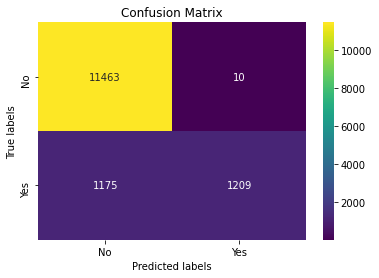

In [40]:
# Creating predictions
y_pred = forest_opt.predict(X_test)

# Generating labels
labels = [0,1]

# Confusion Matrix
cm = metrics.confusion_matrix(y_true = y_test, y_pred = y_pred, labels = labels)

# Vislualizing the conufsion matrix
ax = plt.subplot()
sns.heatmap(cm, annot = True, fmt = '.0f', ax = ax, cmap = "viridis")

# Labels etc
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['No', 'Yes']); ax.yaxis.set_ticklabels(['No', 'Yes'])

Additionally, the recall, precision, and f1 values are printed out below in the classification report.  The random forest model has a precision of 0.99 and recall of 0.51 for the predicted readmission class.  The resulting f1 score is 0.67. 

In [41]:
pred_grid_search = forest_opt.predict(X_test)
print(classification_report(y_test, pred_grid_search))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     11473
           1       0.99      0.51      0.67      2384

    accuracy                           0.91     13857
   macro avg       0.95      0.75      0.81     13857
weighted avg       0.92      0.91      0.90     13857



**Feature Importance**

With a random forest model, we are able to determine the estimated feature importance for the predictions.  The feature importance is calculated below and then the table is sorted and printed to visualize each feature and its respective importance. 

In [42]:
# Creating DataFrame with the features names and features importance
F_importance = pd.concat([pd.DataFrame(X.columns,columns=['Features']),
                  pd.DataFrame(np.transpose(forest_opt.feature_importances_),columns=['Feature Importance'])],
                 axis = 1)

# Sorting new DataFrame by feature importance (Sort Descending)
F_importance = F_importance.sort_values(by='Feature Importance', ascending=False)
F_importance

,Features,Feature Importance
2,number_diagnoses,0.298568
8,number_outpatient,0.188802
6,number_emergency,0.115449
1,los,0.067417
4,num_procedures,0.046709
...,...,...
11,max_glu_serum_>200,0.001047
12,max_glu_serum_>300,0.000931
19,group_name_1_Blood_&_immune,0.000930
60,admission_type_grouped_Newborn,0.000217


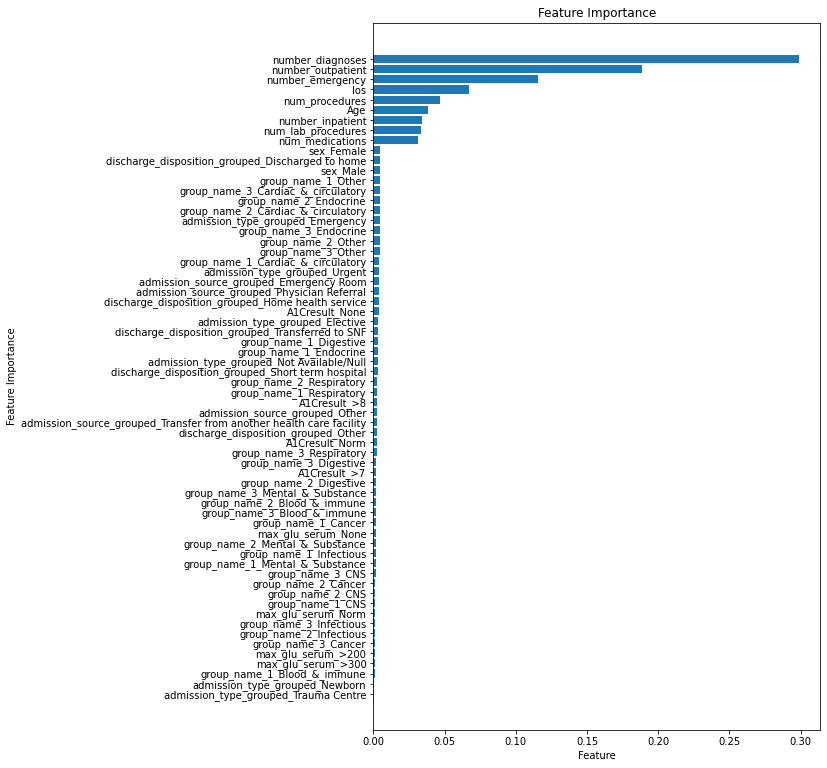

In [43]:
# Ploting the graph to show feature importance

def plot_feature_importances(model):
    plt.rcParams["figure.figsize"] = (8,13)
    # Sort feature importances in ascending order
    indices = np.argsort(model.feature_importances_)
    
    # Rearrange feature names so they match the sorted feature importances
    columns_name = [X.columns[i] for i in indices]
    
    # Create plot
    plt.figure()
    plt.title("Feature Importance")
    plt.xlabel("Feature")
    plt.ylabel("Feature Importance")
    plt.barh(range(X.shape[1]), model.feature_importances_[indices])
    plt.yticks(range(X.shape[1]), columns_name)
    plt.show()
    
plot_feature_importances(forest_opt)


From looking at the feature performance ranking of the variables, it seems that the following parameters have a big influence on the outcome of whether the patient would be readmitted or not:

1. Number of diagnosis
2. Number of Outpatient
3. Number of ED visits
4. Number of procedues done
5. Age
6. Number of inpatient visits
7. Number of diagnositic test done
8. Number of medications

It seems that the model seems to be training well, as these variables are reasonable indicators which affects readmission.

**Imbalance Data Set**

In [44]:
hospital['readmission'].value_counts()

no     57362
yes    11921
Name: readmission, dtype: int64

The hospital set is class-imbalanced. There are significantly more people who are not readmitted, as compaered to people who were readmitted to hospital.

As a result, it is challenging to create an appropriate testing and training data sets, given that most classifiers are built with the assumption that the test data is drawn from the same distribution as the training data.

Presenting imbalanced data to a classifier tends to have undesirable results such as a much lower performance on the testing than on the training data. Hoever, for this case, the model produce is able to give a very little difference between testing and training sets, with:

Accuracy on training set: 0.922 Accuracy on test set: 0.914

The algorithm is able to select suitable features as mentioned above to be able to give a more accurate predictions.

# 3.5 Logistic or Forest? Model Comparison and Cost Analysis

Examining the metrics given in the classification reports it can be seen that the logistic model offers a higher recall, but a much lower precision. In the context of the discharge intervention a higher recall is preferred, however, the cost of the program must be taken into account when selecting a model. In an unlimited budget scenario we would be indifferent to spending extra money on the discharge intervention for those not at risk of readmission. It may improve health outcomes for those not at risk, improve the reputation of the hospital, and more. Nevertheless, given a cost restricted scenario we must examine the over under returned by these models should the intervention be implemented.

**Metric Comparison for Readmission**

**Logistic** 

* Recall: .599
* Precision: .433
* F1 score: .503

**Forest Model**

* Recall: .51
* Precision: .99
* F1 score: .67

**Cost Analysis**
The cost of the model implementation alongside the intervention program boils down to a number calculations. First we will make some assumptions to simplify the cost analysis:

1. The cost per person of the discharge intervention is 2,000 AUD. (400 AUD per visit, 5 visit average)
2. The cost per person of readmission is 20,000 AUD. (5,000 AUD per day, 4 days in hospital on average)
3. Every intervention will prevent readmission. (as we don't yet know the how effective the program will be)
4. The money saved per intervention for someone who would be readmitted is 18,000 AUD. (Cost of hospital readmission minus cost of intervention = 20,000 - 2,000 = 18,000 AUD)

From these assumptions we can perform an analysis. Money is saved per every intervention on someone who would be readmitted. Money is lost when either the intervention is used on someone who would not be readmitted or not used on someone who would be readmitted.

**Logistic Model:**

From the confusion matrix we see the logistic model correctly says we should use the intervention on 1427 people, says we should use the intervention on 1868 who don't need it, and should not use the intervention on 957 people who do need it. Thus:

* Money lost from using the intervention on those who didn't need it: (1868)(2000) = 3,736,000 AUD
* Money lost from not using the intervention on someone who did need it: (957)(20000) = 19,140,000 AUD
* Money saved from implementing the intervention on someone who needed it: (1427)(18000) = 25,686,000 AUD

Thus we can calculate that overall the implementation of the logistic model under the assumptions above will save 25,686,000 - 3,736,000 - 19,140,000 = 2,810,000 AUD if it were used on the data at hand.

Alternitavely we could approximate the cost of the intervention over the long term. We will assume the proportion of readmissions, the ratio of correctly identified patients who needed the intervention and would get it, didn't need intervention but got it, and needed the intervention but didn't it on the test sample data.  Using this, we can approximate their true values. Then we could calculate the expected cost per person of the intervention given that we use the logistic model to identify patients (note money saved is positive, money cost is negative, the total amount of patients is 13857. A positive expected value indicates money saved per person, negative represents money lost per person):

E(intervention cost per person using logistic model as identifier) = $\frac{1868}{13857}(-2000)+\frac{957}{13857}(-20000)+\frac{1427}{13857}(18000)+\frac{9605}{13857}(0) = 202.79$

**Forest Model**

From the confusion matrix we see the forest model correctly says we should use the intervention on 1209 people, says we should use the intervention on 10 who don't need it, and should not use the intervention on 1175 people who do need it. Thus:

* Money lost from using the intervention on those who didn't need it: (10)(2000) = 20,000 AUD
* Money lost from not using the intervention on someone who did need it: (1175)(20000) = 23,500,000 AUD
* Money saved from implementing the intervention on someone who needed it: (1209)(18000) = 21,762,000 AUD

Thus we can calculate that overall the implementation of the logistic model under the assumptions above will save 21,762,000 - 23,500,000 - 20,000 = -1,758,000 AUD if the model were used on the data at hand.  The negative value indicates that this implementation would actually result in a loss of overall money. 

Similar to the logistic model, we may be interested in knowing how much the intervention will cost per person on average given that we use the forest model to identify who should recieve the intervention treatment. (note money saved is positive, money cost is negative, the total amount of patients is 13857. A positive expected value indicates money saved per person, negative represents net cost per person):

E(intervention cost per person using the forest as an identifier) = $\frac{10}{13857}(-2000)+\frac{1175}{13857}(-20000)+\frac{1209}{13857}(18000)+\frac{11463}{13857}(0) = -126.87$

**Discussion**

Given the structure we preformed our analysis under the logistic model is preferred as it actually saves the hospital money both given our data and on average in the long run. Of course, if the intervention doesn't prevent readmissions at a rate that keeps the expected value positive then the intervention would not be worth it using the logistic model either. This analysis was conducted under a "best case" scenario assuming every intervention would prevent readmission. Thus, more knowledge on the effectiveness of the discharge intervention is needed to have a proper discussion on if the intervention is economically feasible or not. However, from the stand point of chosing one model over another, the logistic model is to be preferred.

# 3.6 LIME and SHAP Analysis

LIME and SHAP are tools that help explain how our model makes predictions.  From above, we will use the logistic regression model, with parameters C = 0.002, class weight = (0.1,0.9) and penalty = l1, as the final model.  

For this, we will use one patient from the 'X_test' dataset that the model has not seen in the training data, and treat is a brand new patient.  

Below, we analyze this prediction first using LIME. To do this,  I first need to re-fit the final logistic regression model using the optimal hyper-parameters found in section 3.1.  

In [8]:
#define the scaler and fit to X_train
scaler = StandardScaler()
scaler.fit(X_train)

#scale the X_train and X_test data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#fit the final logistic regression model using the tuned hyper-parameters
Log_Reg_Final = LogisticRegression(C = 0.002 , penalty = 'l1', class_weight = {0: 0.1, 1: 0.9},  solver='liblinear')
Log_Reg_Final.fit(X_train_scaled, y_train) 


# Adding the explainer for Lime algorithm
explainer = lime.lime_tabular.LimeTabularExplainer(X_train_scaled,
                                                   feature_names=X_train.columns.values.tolist(),
                                                   class_names=np.unique(y_train))

Below, we can use the explainer defined above to explain and visualize the predicition for a given patient.  For each patient, we can observe the predicted probabilities of each class, as well as the feature importance and value that resulted in the given prediction.  

In the example below, the test patient had a predicted probability of 0.59 for no readmission and 0.41 for readmission. Therefore, this patient was predicted as a non-readmission.  The number_outpatient, number_emergency, and number_diagnoses were all important features that supported the prediction for class 0, or non-readmission.  A few of the features concerning diagnoses contributed to the predicted probability for readmission.

In [10]:
# Get the explanation for the final logistic regression model
exp = explainer.explain_instance(X_test_scaled[0], Log_Reg_Final.predict_proba, num_features=10)
exp.show_in_notebook()

![title](pic.png)

SHAP is another algorithm that can be used to explain predictions and feature importance for the final logistic regression model.  Compared to the LIME method above, SHAP provides a global explanation to summarize the effects of the features.  

In [19]:
# Using SHAP to explain predictions
explainer_Model1 = shap.LinearExplainer(Log_Reg_Final, X_train_scaled, feature_dependence="independent")       
shap_values_Model1_train = explainer_Model1.shap_values(X_train_scaled)

Now, we can visualize the SHAP summary plot to observe the feature importance. Every instance of the training data is included in the plot below to help explain the global sense of the model.  

It is clear that number_outpatient and number_emergency are the most influential features supporting the readmission prediction. When patients have a higher value of either feature, they are more likely to be readmissions.  Similarly, we observe that a higher number of number_diagnoses and los also results in patients more likely to be readmitted, though the effect in less influential. 

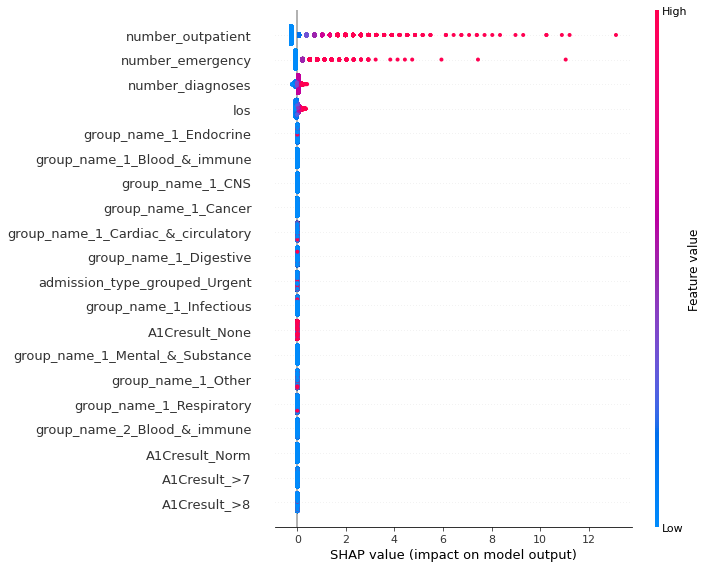

In [20]:
# Summary plot - SHAP
shap.summary_plot(shap_values_Model1_train, X_train_scaled, feature_names= X_train.columns)